In [1]:
%load_ext autoreload
%autoreload 2

# Run Simulation

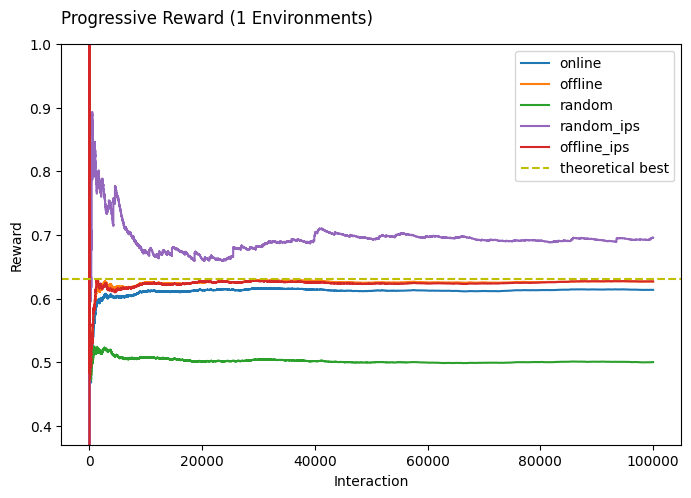

In [2]:
import ast
import pandas as pd
from datetime import datetime
import coba as cb
import numpy as np
import matplotlib.pyplot as plt
from coba.experiments.results import CustomResult
from coba.primitives.rewards import SequenceReward
from coba.environments.banditreplay import BanditReplay

SAMPLE_COUNT = 100_000
class CustomEnvironment:

    def __init__(self, n_interactions):
        self._n_interactions = n_interactions

    def read(self):
        rng = cb. CobaRandom(1) #so the simulation is repeatable
        for _ in range(self._n_interactions):
            features = rng.randoms(3)
            context  = dict(zip(['feature_1','feature_2','feature_3'],features))
            rewards  = SequenceReward(np.random.binomial(1, np.clip([features[0]-.5*features[1]+.25, .5],0,1)).tolist())
            yield { 'context': context, "actions": [0,1], "rewards": rewards}

online_learners     = cb.VowpalSoftmaxLearner(features=[1, 'x', 'a', 'ax', 'axx'])
online_environments = cb.Environments(CustomEnvironment(SAMPLE_COUNT))#.shuffle(n=5)
online_logged       = cb.SimpleEvaluation(record=['context','actions','rewards','action','reward','probability','ope_loss'])
online_result       = cb.Experiment(online_environments, online_learners, evaluation_task=online_logged).run(quiet=True)

# CSV serialization
df = online_result.interactions.to_pandas()
file_name = f"custom_env_mr_{datetime.now()}.csv"
df.to_csv(file_name)
df_csv = pd.read_csv(file_name, converters={column: ast.literal_eval for column in
                                            ['context', 'action', 'actions', 'probability', 'reward', 'rewards']})

offline_learners     = [cb.VowpalOffPolicyLearner([1, 'x', 'a', 'ax', 'axx']), cb.RandomLearner()]
offline_environments = BanditReplay(df_csv)
offline_result       = cb.Experiment(offline_environments, offline_learners, evaluation_task=online_logged).run(quiet=True)

# test IPS estimation in place of the simulated rewards
df_csv = df_csv.drop(columns=['rewards'])
offline_learners_ips     = [cb.VowpalOffPolicyLearner([1, 'x', 'a', 'ax', 'axx']), cb.RandomLearner()]
offline_environments_ips = BanditReplay(df_csv)
offline_result_ips       = cb.Experiment(offline_environments_ips, offline_learners_ips, evaluation_task=online_logged).run(quiet=True)

plt.figure(figsize=(8,8))
online_result.plot_learners(labels=['online'],colors=[0],out=None)
offline_result.plot_learners(labels=['offline','random'],colors=[1],out=None)
offline_result_ips.plot_learners(labels=['offline_ips','random_ips'],colors=[3],out=None)
plt.axhline(y = 0.63, color = 'y', linestyle = '--', label='theoretical best')
plt.legend()
plt.ylim(.37,1)
plt.show()

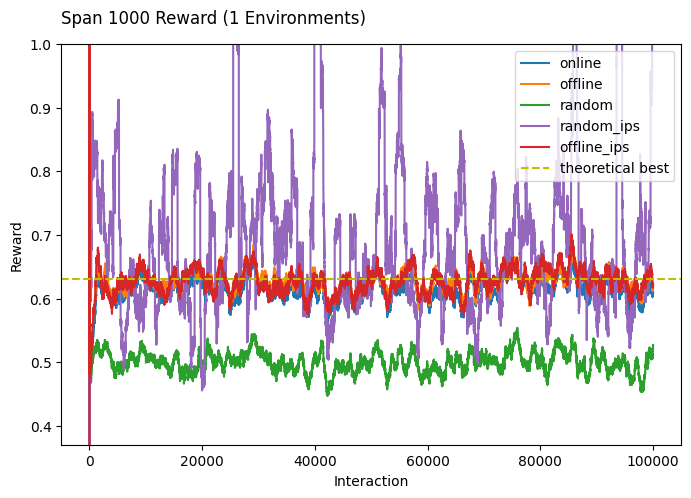

In [3]:
plt.figure(figsize=(8,8))
online_result.plot_learners(span=1000, labels=['online'],colors=[0],out=None)
offline_result.plot_learners(span=1000, labels=['offline','random'],colors=[1],out=None)
offline_result_ips.plot_learners(span=1000, labels=['offline_ips','random_ips'],colors=[3],out=None)
plt.axhline(y = 0.63, color = 'y', linestyle = '--', label='theoretical best')
plt.legend()
plt.ylim(.37,1)
plt.show()

In [4]:
# random higher because of scaling with dividing by probability
offline_result.__class__ = CustomResult
offline_result.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_adf --random_seed 1 --interactions a...,0.62676,0.99999,-0.312569,NaN
1,random: N/A,0.49996,0.50000,0.000000,NaN


In [5]:
offline_result_ips.__class__ = CustomResult
offline_result_ips.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
1,random: N/A,0.695746,0.50000,0.000000,NaN
0,vw: --cb_adf --random_seed 1 --interactions a...,0.626924,0.99999,-0.312569,NaN


In [6]:
online_result.__class__ = CustomResult
online_result.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_explore_adf --softmax --lambda 10 --r...,0.61364,0.821709,-0.306578,NaN


In [7]:
df = offline_result.interactions.to_pandas()
df

,environment_id,learner_id,index,reward,action,actions,context,ope_loss,probability,rewards
0,0,0,1,0,0,"[0, 1]","{'feature_1': 0.10863548330962658, 'feature_2'...",0.000000,0.5,"[0, 0]"
1,0,0,2,1,1,"[0, 1]","{'feature_1': 0.17055912036448717, 'feature_2'...",0.000000,0.5,"[0, 1]"
2,0,0,3,1,1,"[0, 1]","{'feature_1': 0.3063608556985855, 'feature_2':...",-1.002878,1.0,"[1, 1]"
3,0,0,4,0,1,"[0, 1]","{'feature_1': 0.8652601158246398, 'feature_2':...",-1.002878,1.0,"[1, 0]"
4,0,0,5,1,1,"[0, 1]","{'feature_1': 0.9996601808816195, 'feature_2':...",-2.180652,1.0,"[1, 1]"
...,...,...,...,...,...,...,...,...,...,...
199995,0,1,99996,1,1,"[0, 1]","{'feature_1': 0.9169877311214805, 'feature_2':...",NaN,0.5,"[1, 1]"
199996,0,1,99997,0,0,"[0, 1]","{'feature_1': 0.10253624059259892, 'feature_2'...",NaN,0.5,"[0, 0]"
199997,0,1,99998,1,1,"[0, 1]","{'feature_1': 0.16599745396524668, 'feature_2'...",NaN,0.5,"[0, 1]"
199998,0,1,99999,1,1,"[0, 1]","{'feature_1': 0.3734978102147579, 'feature_2':...",NaN,0.5,"[0, 1]"


In [8]:
df_ips = offline_result_ips.interactions.to_pandas()
df_ips

,environment_id,learner_id,index,reward,action,actions,context,ope_loss,probability,rewards
0,0,0,1,0.000000,0,"[0, 1]","{'feature_1': 0.10863548330962658, 'feature_2'...",0.000000,0.5,"[0.0, 0.0]"
1,0,0,2,2.000000,1,"[0, 1]","{'feature_1': 0.17055912036448717, 'feature_2'...",0.000000,0.5,"[0.0, 2.0]"
2,0,0,3,1.002876,1,"[0, 1]","{'feature_1': 0.3063608556985855, 'feature_2':...",-1.002878,1.0,"[0.0, 1.0028758261200568]"
3,0,0,4,0.000000,1,"[0, 1]","{'feature_1': 0.8652601158246398, 'feature_2':...",-1.002878,1.0,"[0.0, 0.0]"
4,0,0,5,1.177775,1,"[0, 1]","{'feature_1': 0.9996601808816195, 'feature_2':...",-2.180652,1.0,"[0.0, 1.1777748043818246]"
...,...,...,...,...,...,...,...,...,...,...
199995,0,1,99996,0.000000,1,"[0, 1]","{'feature_1': 0.9169877311214805, 'feature_2':...",NaN,0.5,"[1.0005086862500736, 0.0]"
199996,0,1,99997,0.000000,0,"[0, 1]","{'feature_1': 0.10253624059259892, 'feature_2'...",NaN,0.5,"[0.0, 0.0]"
199997,0,1,99998,1.236477,1,"[0, 1]","{'feature_1': 0.16599745396524668, 'feature_2'...",NaN,0.5,"[0.0, 1.236477450293539]"
199998,0,1,99999,1.134559,1,"[0, 1]","{'feature_1': 0.3734978102147579, 'feature_2':...",NaN,0.5,"[0.0, 1.1345586706770976]"


In [9]:
random_offline = df[df['learner_id'] == 1]

# Compare the offline random policy with the one using IPS

## Offline (with rewards)

In [10]:
random_offline[random_offline['reward'] == 0].shape

(50004, 10)

In [11]:
sum(random_offline[random_offline['reward'] != 0]['reward']) / SAMPLE_COUNT

0.49996

array([[<AxesSubplot: title={'center': 'reward'}>]], dtype=object)

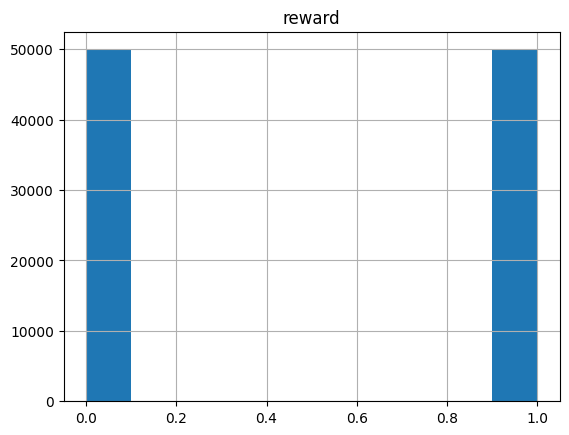

In [12]:
random_offline.hist(column='reward')

## IPS

In [13]:
random_ips = df_ips[df_ips['learner_id'] == 1]
random_ips

,environment_id,learner_id,index,reward,action,actions,context,ope_loss,probability,rewards
100000,0,1,1,0.000000,0,"[0, 1]","{'feature_1': 0.10863548330962658, 'feature_2'...",NaN,0.5,"[0.0, 0.0]"
100001,0,1,2,2.000000,1,"[0, 1]","{'feature_1': 0.17055912036448717, 'feature_2'...",NaN,0.5,"[0.0, 2.0]"
100002,0,1,3,0.000000,0,"[0, 1]","{'feature_1': 0.3063608556985855, 'feature_2':...",NaN,0.5,"[0.0, 1.0028758261200568]"
100003,0,1,4,0.000000,0,"[0, 1]","{'feature_1': 0.8652601158246398, 'feature_2':...",NaN,0.5,"[0.0, 0.0]"
100004,0,1,5,0.000000,0,"[0, 1]","{'feature_1': 0.9996601808816195, 'feature_2':...",NaN,0.5,"[0.0, 1.1777748043818246]"
...,...,...,...,...,...,...,...,...,...,...
199995,0,1,99996,0.000000,1,"[0, 1]","{'feature_1': 0.9169877311214805, 'feature_2':...",NaN,0.5,"[1.0005086862500736, 0.0]"
199996,0,1,99997,0.000000,0,"[0, 1]","{'feature_1': 0.10253624059259892, 'feature_2'...",NaN,0.5,"[0.0, 0.0]"
199997,0,1,99998,1.236477,1,"[0, 1]","{'feature_1': 0.16599745396524668, 'feature_2'...",NaN,0.5,"[0.0, 1.236477450293539]"
199998,0,1,99999,1.134559,1,"[0, 1]","{'feature_1': 0.3734978102147579, 'feature_2':...",NaN,0.5,"[0.0, 1.1345586706770976]"


In [14]:
random_ips[random_ips['reward'] == 0].shape

(63324, 10)

In [15]:
sum(random_ips[random_ips['reward'] != 0]['reward']) / SAMPLE_COUNT

0.6957460960983785

In [16]:
random_ips[random_ips['reward'] > 10]

,environment_id,learner_id,index,reward,action,actions,context,ope_loss,probability,rewards
100225,0,1,226,10.492587,1,"[0, 1]","{'feature_1': 0.21877185720950365, 'feature_2'...",NaN,0.5,"[0.0, 10.492586739247223]"
100318,0,1,319,14.897344,1,"[0, 1]","{'feature_1': 0.5848468504846096, 'feature_2':...",NaN,0.5,"[0.0, 14.897344327497608]"
100392,0,1,393,65.609109,1,"[0, 1]","{'feature_1': 0.5549087282270193, 'feature_2':...",NaN,0.5,"[0.0, 65.60910946725731]"
100487,0,1,488,51.141882,1,"[0, 1]","{'feature_1': 0.4996953858062625, 'feature_2':...",NaN,0.5,"[0.0, 51.14188245093485]"
100824,0,1,825,21.932458,1,"[0, 1]","{'feature_1': 0.6254952754825354, 'feature_2':...",NaN,0.5,"[0.0, 21.9324580954601]"
...,...,...,...,...,...,...,...,...,...,...
199279,0,1,99280,11.154509,1,"[0, 1]","{'feature_1': 0.8693392304703593, 'feature_2':...",NaN,0.5,"[0.0, 11.154508514743988]"
199368,0,1,99369,17.291041,0,"[0, 1]","{'feature_1': 0.5497434195131063, 'feature_2':...",NaN,0.5,"[17.291040893965295, 0.0]"
199545,0,1,99546,224.923169,1,"[0, 1]","{'feature_1': 0.9015618907287717, 'feature_2':...",NaN,0.5,"[0.0, 224.92316922143627]"
199705,0,1,99706,21.567853,1,"[0, 1]","{'feature_1': 0.9310062574222684, 'feature_2':...",NaN,0.5,"[0.0, 21.567852589218575]"


array([[<AxesSubplot: title={'center': 'reward'}>]], dtype=object)

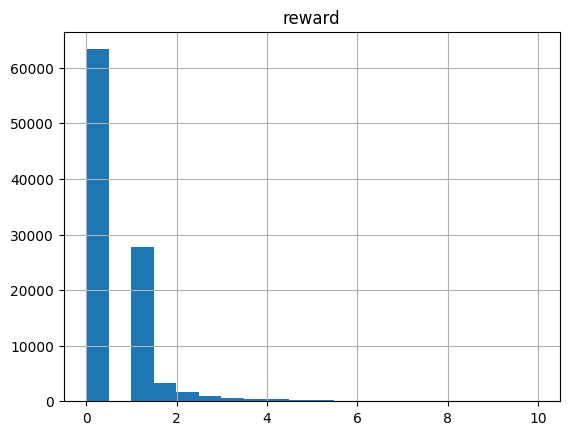

In [17]:
random_ips[random_ips['reward'] < 10].hist(column='reward', bins=20)

In [18]:
sum(random_ips[(random_ips['reward'] != 0) & (random_ips['reward'] < 4)]['reward']) / random_ips[(random_ips['reward'] < 4)].shape[0]

0.4663129576500434

## Takeaways (from the original 5000 sample experiment)
- The IPS policy has higher overall average reward (0.7 vs. 0.5), skeewed by reward outliers of up to 100
- The IPS policy actually has more 0-reward (3180 vs. 2521) interactions
- Clipping the reward outliers to smaller than 4 yields the expected average reward of about 0.5